<a href="https://colab.research.google.com/github/vijaygwu/IntroToDeepLearning/blob/main/LatentSpace_PyTorch_tanh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The provided code defines and utilizes an Autoencoder neural network for the MNIST dataset. Here's a detailed explanation:

- **Autoencoder Class**: This class creates a neural network with encoder and decoder components. The encoder compresses the input image into a lower-dimensional latent space, and the decoder reconstructs the image from this latent space. The network is structured to flatten and process 28x28 grayscale MNIST images.

- **Data Loading**: Utilizes PyTorch's DataLoader to efficiently load the MNIST dataset, applying transformations to normalize the images.

- **Training Loop**: Iterates over the training dataset, feeding batches of images through the model, calculating the reconstruction loss, and updating the model's weights to minimize this loss, effectively learning to compress and reconstruct the input images.

- **Visualization**: After training, the script visualizes a batch of original images and their reconstructions from the autoencoder. It also prints the latent space representations, showcasing what the model has learned to encode.

- **Utility Functions**: Includes `imshow` for displaying tensors as images. It unnormalizes the data and uses Matplotlib to plot them.

This script encapsulates the end-to-end process of training an autoencoder on the MNIST dataset, visualizing the results, and examining the learned latent space.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from torch.cuda.amp import GradScaler, autocast

 The `Autoencoder` class inherits from `nn.Module`, a base class for all neural network modules in PyTorch. Here's a breakdown of the code and its functionality:

### Initialization Method (`__init__`)
- **Parameters**: The `__init__` method accepts a single parameter `encoding_dim`, which specifies the size of the latent space where the input data is compressed.
- **Encoder**: The encoder part of the autoencoder is designed to compress the input data (in this case, an image) into a lower-dimensional representation called the latent space. It consists of a sequence of layers:
  - `nn.Linear(28 * 28, 128)`: This layer flattens the input image (assumed to be 28x28 pixels, typical for MNIST dataset images) into a one-dimensional array and performs a linear transformation to reduce its dimension to 128.
  - `nn.ReLU(True)`: A Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity, helping the model learn complex patterns.
  - Another `nn.Linear(128, encoding_dim)`: Further reduces the dimension from 128 to the specified `encoding_dim`.
  - Another `nn.ReLU(True)`: Another ReLU activation for non-linearity.
- **Decoder**: The decoder part reconstructs the original input data from the compressed representation. It mirrors the encoder structure but in reverse, aiming to expand the compressed data back to its original shape:
  - `nn.Linear(encoding_dim, 128)`: Expands the compressed data from `encoding_dim` back to 128.
  - `nn.ReLU(True)`: Applies ReLU activation.
  - `nn.Linear(128, 28 * 28)`: Transforms the data from 128 back to the flattened image size of 784 (28x28).
  - `nn.tanh()`: Applies the hyperbolic tangent function element-wise to the input tensor.

### Forward Method (`forward`)
- **Parameter**: The `forward` method defines how the input `x` flows through the network.
- **Process**:
  - `x.view(-1, 28*28)`: First, the input `x` is reshaped into a one-dimensional array (flattened) if not already done.
  - `self.encoder(x)`: The flattened `x` is then passed through the encoder.
  - `self.decoder(x)`: The output from the encoder, which is the compressed representation, is fed into the decoder.
- **Output**: The final output is reshaped back to the original image dimensions (`-1, 1, 28, 28`), where `-1` is a placeholder that automatically adjusts based on the batch size.


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: compresses the image into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Flatten the image and then linearly transform it
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, encoding_dim),  # Linear transformation to the encoding dimension
            nn.ReLU(True)  # Non-linear activation function
        )
        # Decoder: reconstructs the image from the latent space
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Linearly transforms the encoding
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, 28 * 28),  # Transforms back to original image shape
            nn.Tanh()  # applies the hyperbolic tangent function element-wise to the input tensor.
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 28*28))  # Encode the input image
        x = self.decoder(x)  # Decode the encoded image
        return x.view(-1, 1, 28, 28)  # Reshape to the original image dimensions

In [ ]:

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert the tensor to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reshape and display the image
    plt.show()

### Transform

Transform is a crucial preprocessing step in many PyTorch workflows, ensuring that images are in the correct format and scale for efficient training of neural networks.

1. **`transforms.Compose([])`**:
   - `transforms.Compose` is a PyTorch function that allows you to chain together multiple image transformations. The transformations are applied in the order they are listed inside the brackets. This is useful when you need to apply several preprocessing steps to your images.

2. **`transforms.ToTensor()`**:
   - This transformation converts a PIL (Python Imaging Library) Image or a NumPy `ndarray` into a PyTorch tensor.
   - **Why is this needed?**
     - **Image to Tensor**: Neural networks in PyTorch expect input data in the form of tensors, so `ToTensor()` is necessary to convert the images from their original format (like JPEG or PNG) into a tensor format that PyTorch can use.
     - **Range Conversion**: `ToTensor()` also scales the pixel values from the range `[0, 255]` (which is typical for image data) to `[0.0, 1.0]`. Each pixel's value is divided by 255.

3. **`transforms.Normalize((0.5,), (0.5,))`**:
   - This transformation normalizes the tensor, adjusting the values so that they have a mean of `0.5` and a standard deviation of `0.5`.
   - **How it works**:
     - The first argument `(0.5,)` specifies the mean value to subtract from each channel (in this case, the only channel since it's grayscale).
     - The second argument `(0.5,)` specifies the standard deviation by which to divide each channel.
    - This transforms the pixel values from the range `[0, 1]` to `[-1, 1]`.

### Why These Transformations?

1. **`ToTensor()`**:
   - Converts the image into a format (tensor) that PyTorch models can work with.
   - Scales the image pixel values to the range `[0.0, 1.0]`, which is a common preprocessing step for neural networks.

2. **Normalization**:
   - **Centered Data**: Normalizing the data to have a mean of 0 and a standard deviation of 1 (or close to it) helps the model learn more efficiently. For many neural networks, it's common to normalize data to have values between `-1` and `1`, which is what this normalization does.
   - **Consistent Data**: Normalization ensures that each input channel (in this case, the grayscale channel) has a similar data distribution, which can speed up the convergence during training.

### Practical Example

If you are working with grayscale images, like the MNIST dataset where images are 28x28 pixels and have only one channel (grayscale), the transformation would work as follows:

- **Original Image**: An image with pixel values ranging from 0 to 255.
- **After `ToTensor()`**: The image is converted to a tensor with values ranging from 0.0 to 1.0.
- **After `Normalize(0.5, 0.5)`**: The pixel values are shifted and scaled so that they fall within the range `[-1, 1]`.



In [ ]:
# Transform: converts images to PyTorch tensors and normalizes them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
# MNIST dataset loading
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8784841.36it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1095338.67it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9498219.94it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12950733.36it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(encoding_dim=64).to(device)
criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer

In [ ]:
# Training loop
num_epochs = 50
scaler = GradScaler()

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        with autocast():
            output = model(img)
            loss = criterion(output, img)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))




<ipython-input-17-2a29fac7d930>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-17-2a29fac7d930>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Loss:0.0269
Epoch [2/50], Loss:0.0249
Epoch [3/50], Loss:0.0280
Epoch [4/50], Loss:0.0263
Epoch [5/50], Loss:0.0300
Epoch [6/50], Loss:0.0273
Epoch [7/50], Loss:0.0250
Epoch [8/50], Loss:0.0281
Epoch [9/50], Loss:0.0253
Epoch [10/50], Loss:0.0210
Epoch [11/50], Loss:0.0238
Epoch [12/50], Loss:0.0248
Epoch [13/50], Loss:0.0246
Epoch [14/50], Loss:0.0249
Epoch [15/50], Loss:0.0218
Epoch [16/50], Loss:0.0246
Epoch [17/50], Loss:0.0255
Epoch [18/50], Loss:0.0212
Epoch [19/50], Loss:0.0222
Epoch [20/50], Loss:0.0229
Epoch [21/50], Loss:0.0221
Epoch [22/50], Loss:0.0245
Epoch [23/50], Loss:0.0182
Epoch [24/50], Loss:0.0215
Epoch [25/50], Loss:0.0212
Epoch [26/50], Loss:0.0206
Epoch [27/50], Loss:0.0230
Epoch [28/50], Loss:0.0238
Epoch [29/50], Loss:0.0231
Epoch [30/50], Loss:0.0222
Epoch [31/50], Loss:0.0232
Epoch [32/50], Loss:0.0200
Epoch [33/50], Loss:0.0213
Epoch [34/50], Loss:0.0210
Epoch [35/50], Loss:0.0245
Epoch [36/50], Loss:0.0280
Epoch [37/50], Loss:0.0192
Epoch [38/

Original Vector Representations:
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0')
Original Images


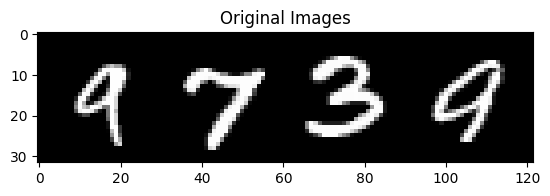

Latent space representations:
tensor([[ 0.0000,  6.3770,  6.4678,  4.0172,  4.7846, 10.9537,  6.5730,  1.7258,
          0.0000,  7.2541,  5.6369,  6.9409,  0.0000,  8.1006,  6.3063,  9.0000,
          0.0000,  1.5493,  0.0000,  5.6072,  0.0000,  0.5637,  0.0000,  2.1501,
          5.7988,  3.0244,  0.0000,  7.9700,  0.0000,  5.8801,  3.1871,  6.0026,
          0.0000,  7.2144,  0.0000,  5.5412,  5.2316,  0.0000,  0.0000,  4.1109,
          0.0000,  0.0000,  8.5169,  0.0000,  0.0000,  8.4391,  7.3572, 10.0229,
          0.0000,  6.9775,  3.2906,  0.0000,  5.5727,  6.3572,  0.0000,  7.3613,
          6.7695,  0.0000,  5.2960,  4.5493,  5.8390,  2.7260,  0.0000,  6.6112],
        [ 0.0000,  2.4577,  6.0125,  3.4825, 10.6451,  2.4035, 10.5031,  7.7219,
          0.0000,  9.8301,  4.5376,  9.0867,  0.0000,  2.8916,  1.4042,  8.9001,
          0.0000,  5.2475,  0.0000,  7.3077,  0.0000,  9.0037,  0.0000,  6.1777,
          6.0487,  6.6091,  0.0000,  8.3514,  0.0000, 10.9628,  5.8370,  8.269

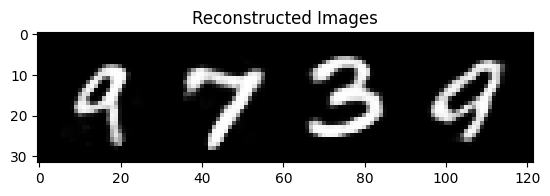

Decoded Image Representations (as vectors):
tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')


In [ ]:
# Function to display a grid of images
def imshow(img, title=None):
    npimg = img.cpu().numpy()  # Move the image to CPU and convert to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Visualization of the original and reconstructed images
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)



# Flatten the images to get their original vector representations
original_vectors = images.view(-1, 28*28)[:4]
print("Original Vector Representations:")
print(original_vectors)

# Display original images
print("Original Images")
imshow(vutils.make_grid(images[:4], normalize=True), title="Original Images")

# Encoded and decoded images
with torch.no_grad():
    # Pass the original vector representations through the encoder to get latent space representations
    encoded_imgs = model.encoder(original_vectors)

    # Decode the latent space representations back into images
    decoded_imgs = model.decoder(encoded_imgs).view(-1, 1, 28, 28)

# Print latent space representations
print("Latent space representations:")
print(encoded_imgs)


# Display reconstructed images
print("Reconstructed Images")
imshow(vutils.make_grid(decoded_imgs, normalize=True), title="Reconstructed Images")

# Flatten the decoded images to print their vector representations
decoded_vectors = decoded_imgs.view(-1, 28*28)
print("Decoded Image Representations (as vectors):")
print(decoded_vectors)
